![](https://europe-west1-atp-views-tracker.cloudfunctions.net/working-analytics?notebook=tutorials--a2a--a2a-tutorial)

# A2A (Agent-to-Agent) Communication Protocol - Tutorial

## Introduction

### The Agent2Agent (A2A) Protocol

The Agent2Agent (A2A) Protocol is an open standard communication protocol designed to help AI agents talk to each other.

#### Key benefits:
- Enables agents built with different tools to communicate
- Works across different programming languages
- Facilitates collaboration between agents from different companies

This tutorial will guide you through a simulated implementation of A2A principles, demonstrating how agents can collaborate on a task.

We will focus on the message structures and interaction patterns described in the
[A2A Protocol Specification (Version 0.1.0)](https://google.github.io/A2A/specification/).

### Key Goals of A2A

- Discover capabilities for all agents
- Negotiate interaction modalities (text, files, structured data)
- Manage collaborative tasks
- Securely exchange information to achieve user goals

## Why A2A ?

TLDR;  interoperability.
A2A aims to address some key challenges such as:

- **Integration Complexity**: Reducing the need for custom integrations between agents.
- **Protocol Inconsistencies**: Standard way allowing messages exchange and tasks management.
- **Scalability**: Build complex systems from multiple agents.

By defining such common protocol, A2A promises a more modular, flexible, and collaborative path building AI systems.

## Key A2A Concepts

Before diving in straight to the implementation, let's review some core concepts from the A2A specification that we'll be simulating:

- **Agent Card :** Describes an agent's capabilities, authentication requirements, and how to interact with it. (We won't implement full discovery but will assume agents know of each other for this tutorial).
- **Task Object :** The central data object representing a piece of work to be done. It has an ID, status, messages, artifacts, etc.
- **Message Object :** Represents a conversational turn or a piece of information being exchanged, typically part of a `Task`. It contains `Part` objects.
- **Part Union Type :** Defines the content of a message, such as `TextPart`, `FilePart`, or `DataPart`. We'll primarily use `TextPart`.
- **Artifact Object :** Represents outputs or results generated by a task, like files or structured data.
- **JSON-RPC :** A2A uses JSON-RPC for its remote procedure calls. Key methods include `tasks/send`, `tasks/get`, `tasks/cancel`. We will simulate the structure of these calls and responses.

📖 **For more background on Agent2Agent (A2A) communication and its applications, check out our detailed blog post:** [Google's Agent2Agent (A2A) explained](https://open.substack.com/pub/diamantai/p/googles-agent2agent-a2a-explained?r=336pe4&utm_campaign=post&utm_medium=web&showWelcomeOnShare=false)

*DiamantAI is a top 0.1% newsletter for AI with over 25,000 subscribers, focusing on AI techniques, breakthroughs, and tutorials.*

---


A2A Protocol Components

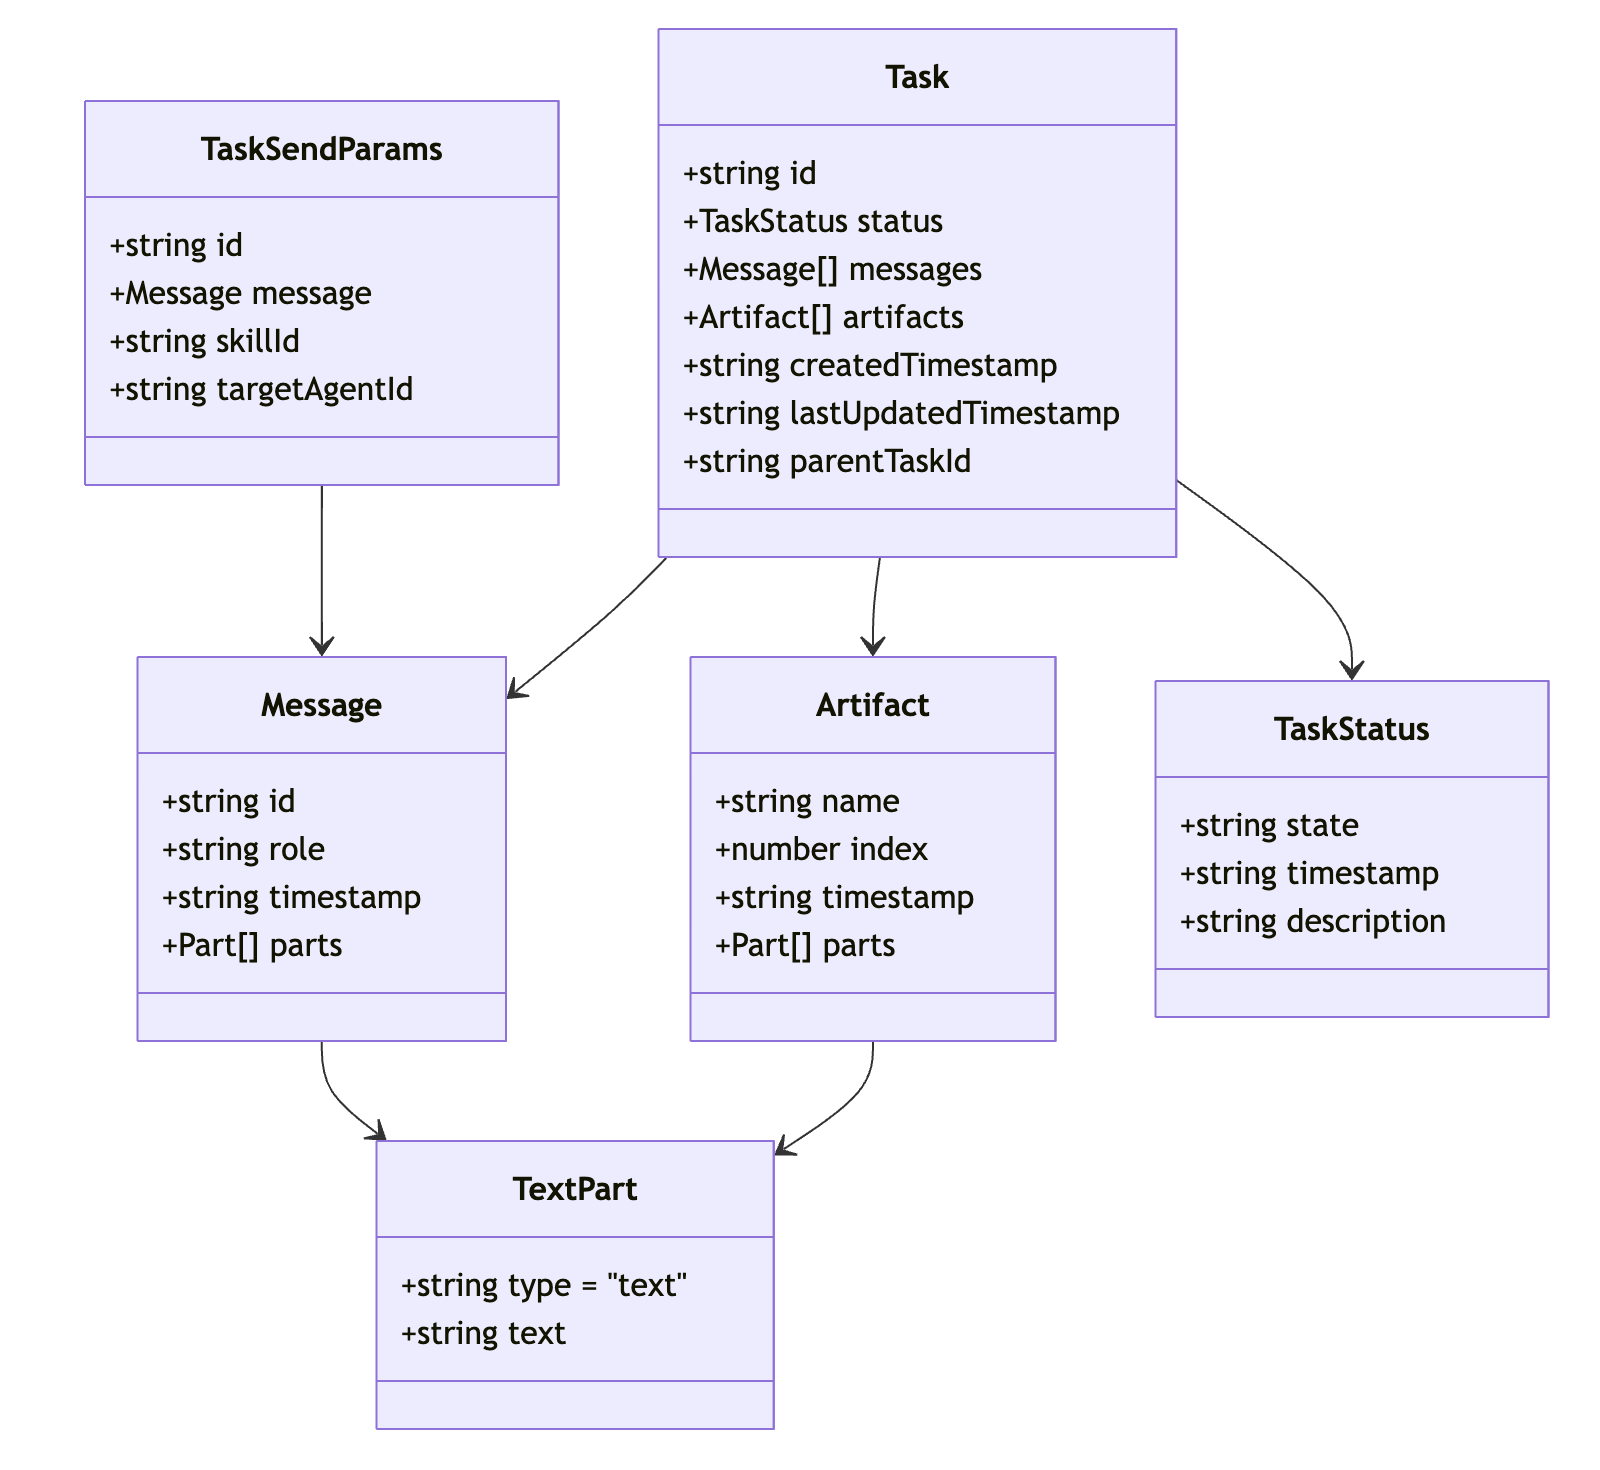

## A2A vs MCP (Model Context Protocol)

We have MCP why do we need A2A?

- **MCP (Model Context Protocol):** Focuses on standardizing how AI models and agents connect to and interact with *tools, APIs, data sources, and other external resources*. It's about how an agent *uses* a capability.
- **A2A (Agent2Agent Protocol):** Focuses on standardizing how independent AI agents *communicate and collaborate with each other as peers*. It's about how agents *partner* or *delegate* work.

They are complementary. An agent participating in an A2A interaction might internally use MCP to fulfill its part of a collaborative task.

## What We'll Build

In this tutorial, we'll simulate a multi-agent system that collaborates to produce a "TLDR (Too Long; Didn't Read) of the day."

We will have three agents:

1. **UserFacingAgent**: This agent is responsible for interacting with the user. It will orchestrate the task of gathering TLDR information.
2. **NewsInfoAgent**: This agent specializes in providing the news-related part of the TLDR.
3. **EventsInfoAgent**: This agent specializes in providing information about current events for the TLDR.

The `UserFacingAgent` will send A2A-like `tasks/send` requests to the `NewsInfoAgent` and `EventsInfoAgent`. These agents will process the requests and return their respective TLDR snippets within A2A-like task objects. Finally, the `UserFacingAgent` will compile these snippets and present the complete TLDR.

# A2A Communication Flow Diagram
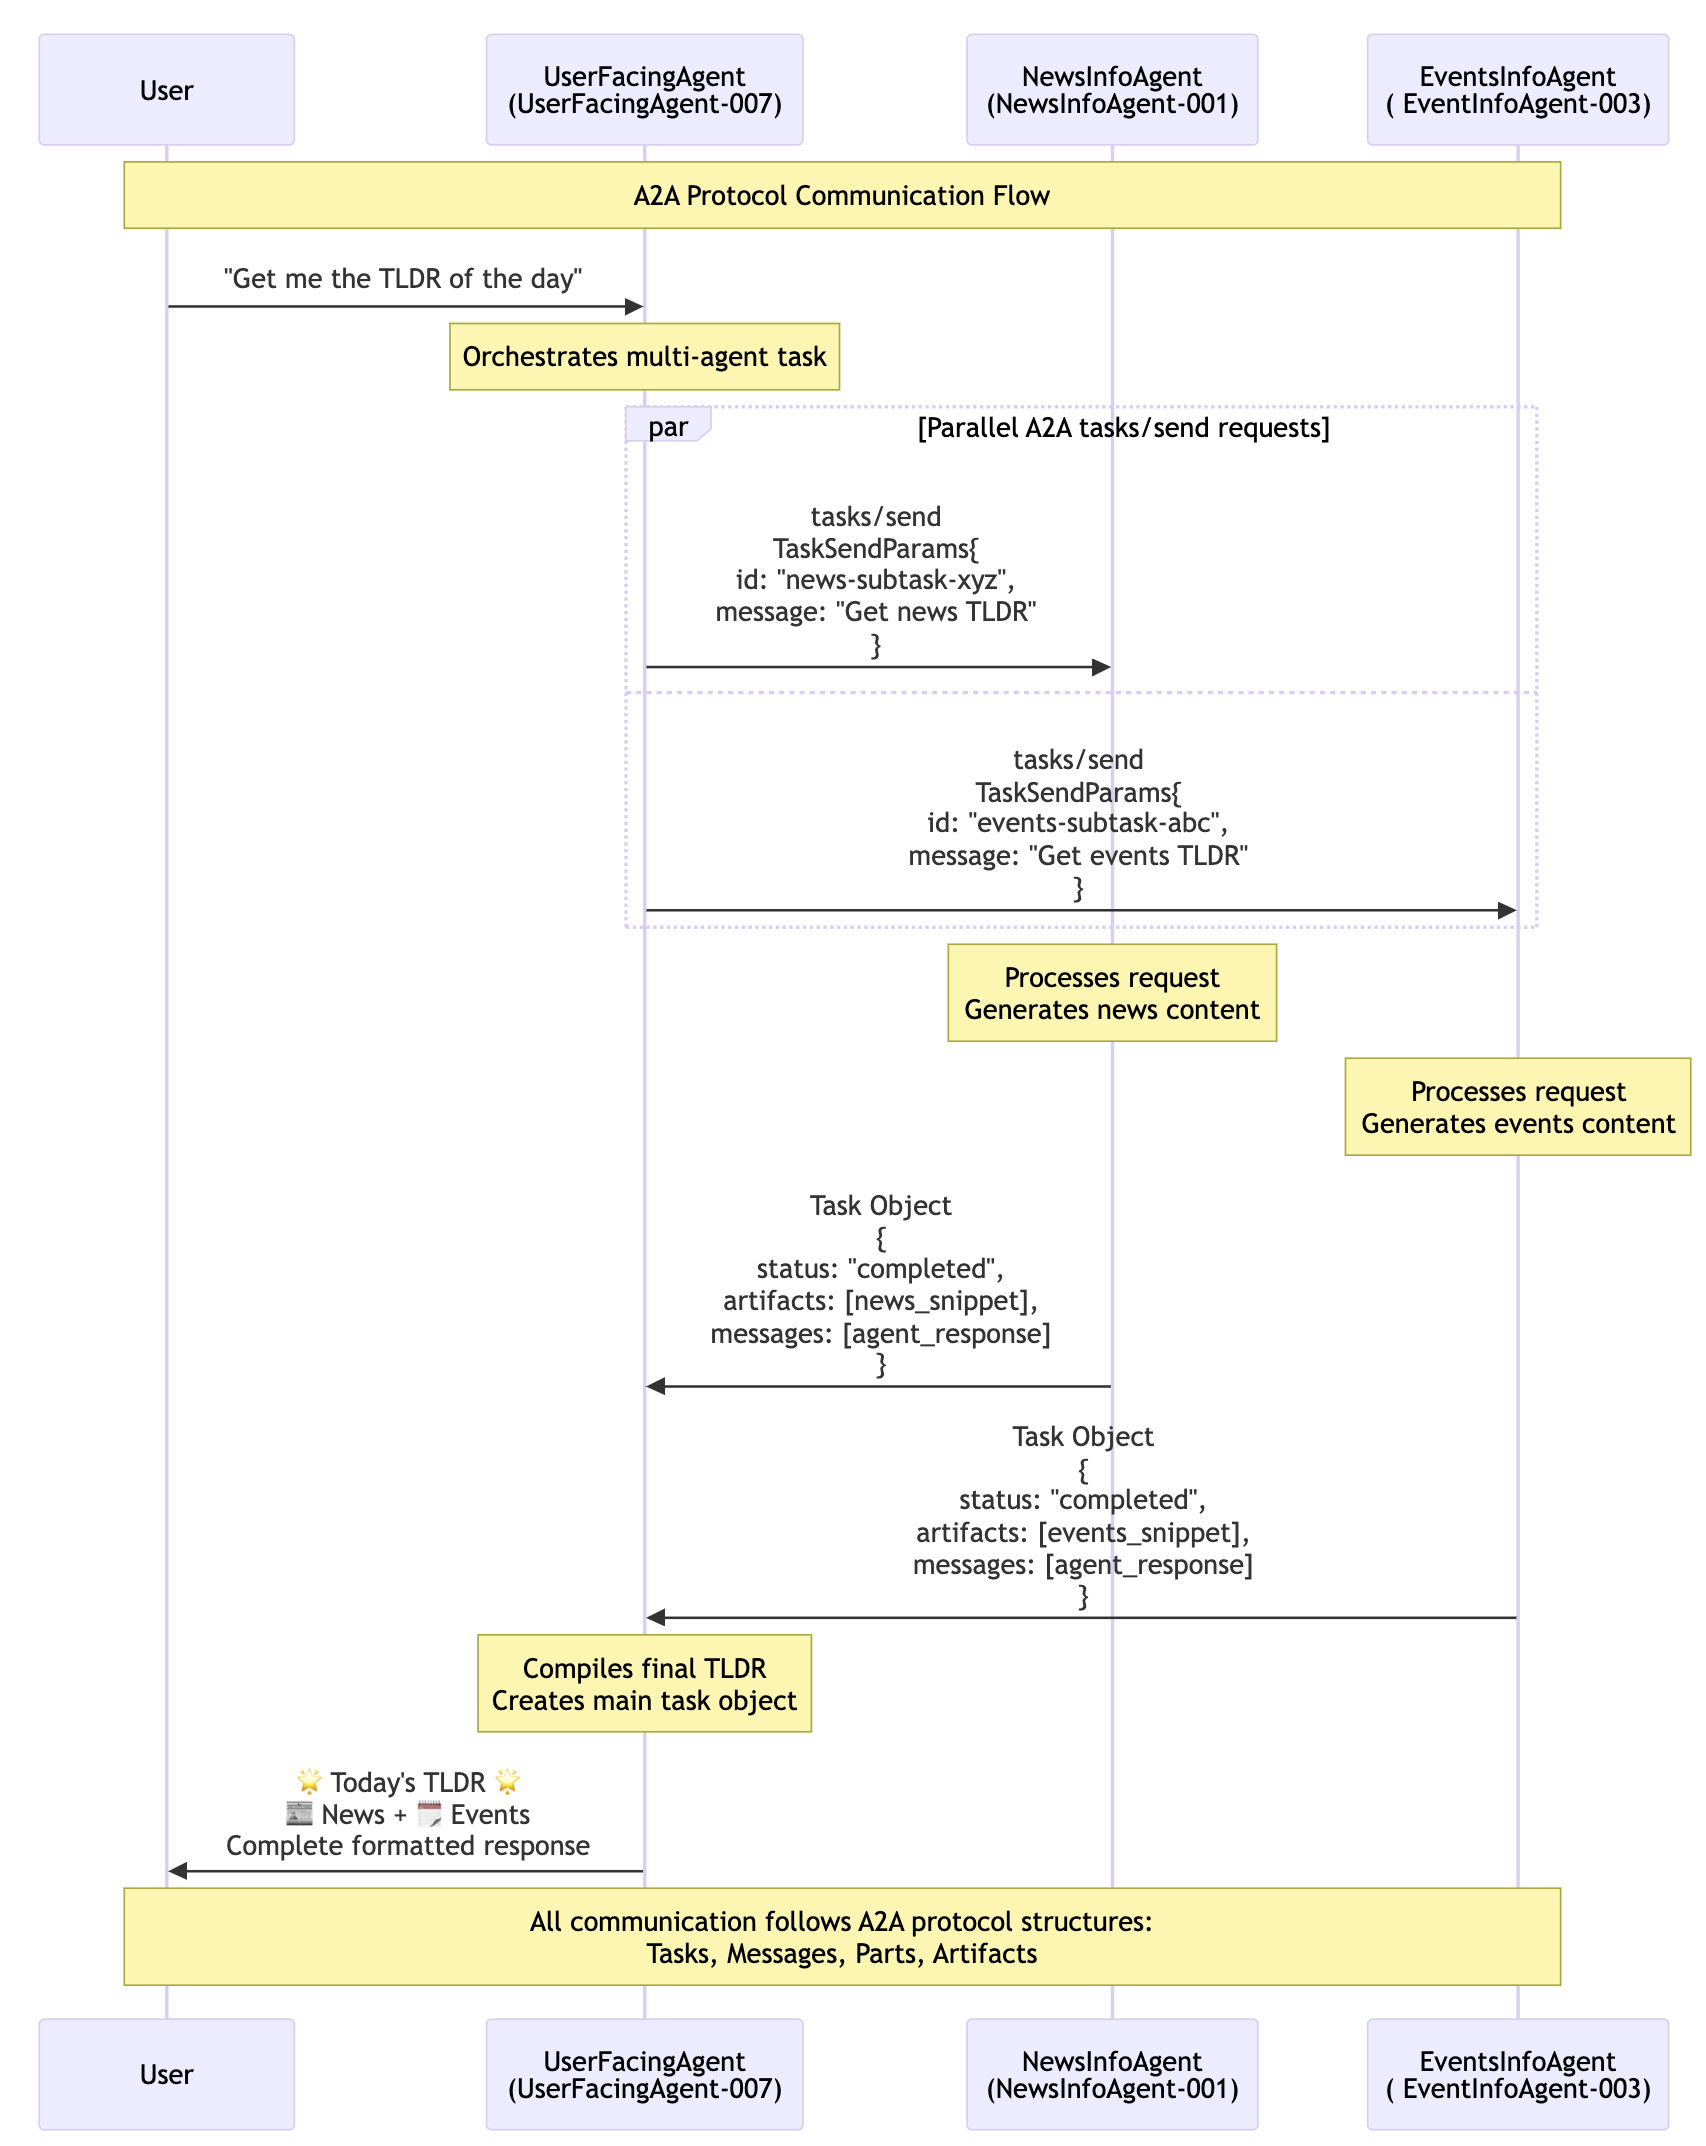

## Setup

This tutorial uses the `a2a-sdk` to demonstrate Agent-to-Agent communication. We'll be focusing on using the SDK's components to build and interact with agents.

**Prerequisites:**
Make sure you have Python installed. You'll also need to install the `a2a-sdk` and other libraries. You can do this by running in your terminal:
```bash
pip install a2a-sdk httpx uvicorn
```
After installation, you may need to restart the Jupyter kernel for the changes to take effect if you were to run pip from within the notebook.


In [ ]:
!pip install a2a-sdk httpx uvicorn

Make sure to restart the runtime in order to use newly installed versions.

### Step 1: Import Required Libraries

First, we'll import the Python libraries we need for our A2A simulation:
- `json`: For handling JSON data structures
- `uuid`: For generating unique identifiers for tasks and messages
- `datetime`: For creating timestamps
- `typing`: For type hints to make our code more robust
- `abc`: For creating abstract base classes

In [ ]:
# Standard library imports
import json
import uuid
import asyncio # For running async client code
import logging
import os

# Third-party imports
import httpx
# uvicorn is mainly for command-line.
# We will instruct users to run servers in separate terminals.

# A2A SDK imports
from a2a.client import A2ACardResolver, A2AClient
from a2a.server.agent_execution import AgentExecutor, RequestContext
from a2a.server.apps import A2AStarletteApplication
from a2a.server.events import EventQueue
from a2a.server.request_handlers import DefaultRequestHandler
from a2a.server.tasks import InMemoryTaskStore # Example task store
from a2a.types import (
    AgentCapabilities,
    AgentCard,
    AgentSkill,
    MessageSendParams,
    SendMessageRequest,
    SendStreamingMessageRequest,
)
from a2a.utils import new_agent_text_message # For agent executor's response

# Configure basic logging for the tutorial
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("A2A_Tutorial_Notebook") # Create a logger specific to this tutorial
logger.info("A2A SDK and libraries imported. Logging configured.")

# Define base URLs for our agents (these will be separate server processes)
NEWS_AGENT_BASE_URL = "http://localhost:9001"
EVENTS_AGENT_BASE_URL = "http://localhost:9002"

# Standard paths for agent cards (as per A2A specification)
PUBLIC_AGENT_CARD_PATH = "/.well-known/agent.json"
EXTENDED_AGENT_CARD_PATH = "/agent/authenticatedExtendedCard" # If we use extended cards

logger.info(f"News Agent will be expected at: {NEWS_AGENT_BASE_URL}")
logger.info(f"Events Agent will be expected at: {EVENTS_AGENT_BASE_URL}")


## Implementing A2A Agents (Server-Side)

Now, let's shift from simulating A2A concepts to using the `a2a-sdk` to build actual agents. We'll start by creating the server-side components for our specialized agents: `NewsInfoAgent` and `EventsInfoAgent`. These agents will run as independent servers.

### Key Server-Side SDK Components:
- **`AgentExecutor`**: This is the core class you'll implement for your agent's logic. It defines how your agent processes requests and generates responses. It has two main methods to implement:
  - `execute(context: RequestContext, event_queue: EventQueue)`: Handles incoming requests. You'll put your agent's primary logic here and use the `event_queue` to send back results (e.g., text messages, errors). The `context` provides information about the request, including the task ID and the incoming message.
  - `cancel(context: RequestContext, event_queue: EventQueue)`: Handles requests to cancel an ongoing task (optional).
- **Agent Logic Class (e.g., `NewsInfoAgent`)**: A helper class that encapsulates the specific business logic of your agent. The `AgentExecutor` will typically instantiate and use this class.
- **`AgentCard` & `AgentSkill`**: These data structures describe your agent's capabilities, how to interact with it, and what specific skills it offers. These are crucial for discovery and interaction.
- **`A2AStarletteApplication`**: A helper from the SDK to quickly set up an A2A compliant web server (using Starlette/FastAPI) for your agent.

### Step 2.1: Define the `NewsInfoAgent` and its `AgentExecutor`

First, we'll create the `NewsInfoAgent`. This agent's responsibility is to provide a piece of news. For simplicity in this tutorial, it will return a static string. Then, we'll create `NewsInfoAgentExecutor` to wrap this logic, making it callable via the A2A protocol.

In [ ]:
from typing import Optional

# NewsInfoAgent: Provides news information
class NewsInfoAgent:
    """A simple agent that provides a static news headline."""
    async def get_latest_news(self, query: Optional[str] = None) -> str:
        # In a real agent, this would involve dynamic logic, API calls, etc.
        # The query parameter could be used to tailor the news.
        logger.info(f"NewsInfoAgent received query: {query}")
        return "Breaking News: AI discovers a new way to make coffee!"


In [ ]:

# NewsInfoAgentExecutor: Implements the A2A AgentExecutor interface
class NewsInfoAgentExecutor(AgentExecutor):
    """Handles A2A requests for the NewsInfoAgent."""

    def __init__(self):
        super().__init__()
        self.agent = NewsInfoAgent()
        logger.info("NewsInfoAgentExecutor initialized.")

    async def execute(
        self,
        context: RequestContext,
        event_queue: EventQueue,
    ) -> None:
        logger.info(f"NewsInfoAgentExecutor executing task: {context.task_id}")
        if context.request_message:
            logger.info(f"Request message content: {context.request_message.model_dump_json(indent=2)}")

        query_text = None
        if context.request_message and context.request_message.message and context.request_message.message.parts:
            for part in context.request_message.message.parts:
                if part.kind == 'text' and hasattr(part, 'text'):
                    query_text = part.text
                    logger.info(f"Extracted query from message: {query_text}")
                    break

        try:
            news_result = await self.agent.get_latest_news(query_text)
            event_queue.enqueue_event(new_agent_text_message(news_result))
            logger.info(f"NewsInfoAgentExecutor successfully sent news: {news_result}")
        except Exception as e:
            error_message = f"Error in NewsInfoAgentExecutor: {str(e)}"
            logger.error(error_message, exc_info=True)
            event_queue.enqueue_event(new_agent_text_message(f"Sorry, an error occurred: {error_message}"))
        finally:
            event_queue.enqueue_event(None)  # Signal completion

    async def cancel(
        self, context: RequestContext, event_queue: EventQueue
    ) -> None:
        logger.warning(f"NewsInfoAgentExecutor received cancel request for task: {context.task_id}, but cancel is not supported.")
        event_queue.enqueue_event(new_agent_text_message("Cancel operation is not supported by this agent."))
        event_queue.enqueue_event(None)  # Signal completion

print("NewsInfoAgent and NewsInfoAgentExecutor classes defined.")

### Step 2.2: Configure the `NewsInfoAgent` Server (AgentCard and Skills)

With the `NewsInfoAgentExecutor` defined, we now need to configure how this agent presents itself to the world. This is done using `AgentSkill` and `AgentCard` objects from the `a2a-sdk`.

- **`AgentSkill`**: Describes a specific capability of the agent. It includes an ID, name, description, tags, and examples of how to invoke it.
- **`AgentCard`**: This is the public-facing description of the agent. It includes its name, description, URL, version, supported input/output modes, overall capabilities (like streaming support), and a list of its skills. It can also indicate support for an `authenticatedExtendedCard` for more privileged operations.

#### Setting up the Request Handler and Application

To make the `NewsInfoAgentExecutor` accessible over the network via the A2A protocol, we need a few more components:

- **`DefaultRequestHandler`**: The SDK provides this handler which wires up an `AgentExecutor` and a `TaskStore` to manage the lifecycle of tasks.
- **`InMemoryTaskStore`**: A simple, non-persistent task store provided by the SDK. For production, you'd likely use a persistent store (e.g., Redis, a database).
- **`A2AStarletteApplication`**: This class wraps everything into a Starlette web application, making it easy to serve the agent. It takes the `AgentCard` and the `http_handler` (our `DefaultRequestHandler`).

The following code cell will set up these components for the `NewsInfoAgent`. We will then provide instructions on how to run this server. **Important:** The server should be run in a separate Python script or terminal, not directly within the notebook, as it's a long-running process.

In [ ]:
# Define the skill for NewsInfoAgent
news_skill = AgentSkill(
    id='get_latest_news',
    name='Get Latest News',
    description='Provides the latest news headline.',
    tags=['news', 'information', 'tldr'],
    examples=['what is the news?', 'latest headline', 'give me news']
)

# Define the AgentCard for NewsInfoAgent
news_agent_card = AgentCard(
    name='News Information Agent',
    description='Provides news headlines for the TLDR of the day.',
    url=NEWS_AGENT_BASE_URL,  # Defined in the import cell
    version='1.0.0',
    defaultInputModes=['text'],
    defaultOutputModes=['text'],
    capabilities=AgentCapabilities(streaming=True), # Our executor supports streaming via EventQueue
    skills=[news_skill],
    supportsAuthenticatedExtendedCard=False # For simplicity, no extended card for this agent
)

logger.info(f"News Agent Card defined: {news_agent_card.name}")

# Instantiate the executor, request handler, and task store
news_agent_executor = NewsInfoAgentExecutor()
news_task_store = InMemoryTaskStore()
news_request_handler = DefaultRequestHandler(
    agent_executor=news_agent_executor,
    task_store=news_task_store,
)

# Create the A2A Starlette Application for the News Agent
news_agent_server_app = A2AStarletteApplication(
    agent_card=news_agent_card,
    http_handler=news_request_handler,
    # extended_agent_card can be provided if supportsAuthenticatedExtendedCard is True
).build() # .build() returns the Starlette app instance

logger.info(f"A2AStarletteApplication for News Agent created and built.")

print("News Agent server configuration is ready. ",
      "See comments above on how to create a separate Python script to run it using uvicorn. ",
      f"It should listen on port 9001 as per NEWS_AGENT_BASE_URL ({NEWS_AGENT_BASE_URL}).")

In [ ]:
# --- How to Run News agent as standalone ---
# The following uvicorn.run command is how you would typically start this server.
# IMPORTANT: Do NOT run this directly in the notebook cell as it will block the kernel.
# Instead, you should create a separate Python file (e.g., run_news_agent.py),
# copy the necessary class definitions (NewsInfoAgent, NewsInfoAgentExecutor) and
# the server setup code (AgentSkill, AgentCard, ..., news_agent_server_app creation) into it,
# and then add the uvicorn.run command at the end of that file.

# Example for run_news_agent.py:
# ```python
# # (Paste NewsInfoAgent, NewsInfoAgentExecutor class definitions here)
# # (Paste AgentSkill, AgentCard, news_agent_executor, news_task_store, news_request_handler, news_agent_server_app setup here)
# import uvicorn # Make sure to import uvicorn in the script
#
# if __name__ == '__main__':
#     logger.info(f"Starting News Agent server on {NEWS_AGENT_BASE_URL}")
#     uvicorn.run(news_agent_server_app, host='0.0.0.0', port=9001) # Port matches NEWS_AGENT_BASE_URL
# ```

### Step 2.3: Define the `EventsInfoAgent` and its `AgentExecutor`

Next, we'll create the `EventsInfoAgent`. This agent is responsible for providing information about current events. Similar to the `NewsInfoAgent`, it will return a static string for simplicity in this tutorial. We will then create its corresponding `EventsInfoAgentExecutor`.

In [ ]:
# EventsInfoAgent: Provides event information
class EventsInfoAgent:
    """A simple agent that provides a static event update."""
    async def get_current_events(self, query: Optional[str] = None) -> str:
        # In a real agent, this would involve dynamic logic, API calls, etc.
        logger.info(f"EventsInfoAgent received query: {query}")
        return "Current Event: The annual 'Innovate AI' conference is happening this week!"

# EventsInfoAgentExecutor: Implements the A2A AgentExecutor interface
class EventsInfoAgentExecutor(AgentExecutor):
    """Handles A2A requests for the EventsInfoAgent."""

    def __init__(self):
        super().__init__()
        self.agent = EventsInfoAgent()
        logger.info("EventsInfoAgentExecutor initialized.")

    async def execute(
        self,
        context: RequestContext,
        event_queue: EventQueue,
    ) -> None:
        logger.info(f"EventsInfoAgentExecutor executing task: {context.task_id}")
        if context.request_message:
            logger.info(f"Request message content: {context.request_message.model_dump_json(indent=2)}")

        query_text = None
        if context.request_message and context.request_message.message and context.request_message.message.parts:
            for part in context.request_message.message.parts:
                if part.kind == 'text' and hasattr(part, 'text'):
                    query_text = part.text
                    logger.info(f"Extracted query from message: {query_text}")
                    break

        try:
            event_result = await self.agent.get_current_events(query_text)
            event_queue.enqueue_event(new_agent_text_message(event_result))
            logger.info(f"EventsInfoAgentExecutor successfully sent event info: {event_result}")
        except Exception as e:
            error_message = f"Error in EventsInfoAgentExecutor: {str(e)}"
            logger.error(error_message, exc_info=True)
            event_queue.enqueue_event(new_agent_text_message(f"Sorry, an error occurred: {error_message}"))
        finally:
            event_queue.enqueue_event(None) # Signal completion

    async def cancel(
        self, context: RequestContext, event_queue: EventQueue
    ) -> None:
        logger.warning(f"EventsInfoAgentExecutor received cancel request for task: {context.task_id}, but cancel is not supported.")
        event_queue.enqueue_event(new_agent_text_message("Cancel operation is not supported by this agent."))
        event_queue.enqueue_event(None) # Signal completion

logger.info("EventsInfoAgent and EventsInfoAgentExecutor classes defined.")

### Step 2.4: Configure the `EventsInfoAgent` Server (AgentCard and Skills)

Now we will configure the server for the `EventsInfoAgent`. This process is very similar to what we did for the `NewsInfoAgent`. We'll define its `AgentSkill` and `AgentCard`.

#### Setting up the Request Handler and Application for `EventsInfoAgent`

Next, we set up the `DefaultRequestHandler`, `InMemoryTaskStore`, and `A2AStarletteApplication` for the `EventsInfoAgent`. Again, remember that this server should be run in a separate Python script or terminal.

In [ ]:
# Define the skill for EventsInfoAgent
events_skill = AgentSkill(
    id='get_current_events',
    name='Get Current Events',
    description='Provides information about current events.',
    tags=['events', 'information', 'tldr', 'conference'],
    examples=['what are the current events?', 'any ongoing events?', 'tell me about events']
)

# Define the AgentCard for EventsInfoAgent
events_agent_card = AgentCard(
    name='Current Events Information Agent',
    description='Provides updates on current events for the TLDR of the day.',
    url=EVENTS_AGENT_BASE_URL,  # Defined in the import cell
    version='1.0.0',
    defaultInputModes=['text'],
    defaultOutputModes=['text'],
    capabilities=AgentCapabilities(streaming=True), # Supports streaming
    skills=[events_skill],
    supportsAuthenticatedExtendedCard=False
)

logger.info(f"Events Agent Card defined: {events_agent_card.name}")

# Instantiate the executor, request handler, and task store
events_agent_executor = EventsInfoAgentExecutor()
events_task_store = InMemoryTaskStore()
events_request_handler = DefaultRequestHandler(
    agent_executor=events_agent_executor,
    task_store=events_task_store,
)

# Create the A2A Starlette Application for the Events Agent
events_agent_server_app = A2AStarletteApplication(
    agent_card=events_agent_card,
    http_handler=events_request_handler,
).build()

logger.info(f"A2AStarletteApplication for Events Agent created and built.")

# --- How to Run This Server ---
# Similar to the News Agent, this server should be run in a separate Python file (e.g., run_events_agent.py).
# Copy the EventsInfoAgent, EventsInfoAgentExecutor class definitions, and the server setup code above into it.

# Example for run_events_agent.py:
# ```python
# # (Paste EventsInfoAgent, EventsInfoAgentExecutor class definitions here)
# # (Paste events_skill, events_agent_card, events_agent_executor, etc. setup here)
# import uvicorn
#
# if __name__ == '__main__':
#     logger.info(f"Starting Events Agent server on {EVENTS_AGENT_BASE_URL}")
#     uvicorn.run(events_agent_server_app, host='0.0.0.0', port=9002) # Port matches EVENTS_AGENT_BASE_URL
# ```

print("Events Agent server configuration is ready. ",
      "See comments above on how to create a separate Python script to run it using uvicorn. ",
      f"It should listen on port 9002 as per EVENTS_AGENT_BASE_URL ({EVENTS_AGENT_BASE_URL}).")

### Part 3: Client-Side Interaction with Agents

Now that we have defined two agent servers (`NewsInfoAgent` and `EventsInfoAgent`) and know how to run them, let's see how a client application can discover and interact with them using the `a2a-sdk`.

#### Step 3.1: Discovering Agents with `A2ACardResolver`

The `A2ACardResolver` helps in fetching the `AgentCard` from an agent's well-known URI. This card contains metadata about the agent, including its capabilities and skills.

In [ ]:
import asyncio
import httpx

# Fix the import - use a2a.client instead of a2a.sdk.public_api
from a2a.client import A2ACardResolver

# Ensure your agent servers (NewsInfoAgent on port 9001, EventsInfoAgent on port 9002) are running separately!
async def resolve_agent_cards():
    async with httpx.AsyncClient() as http_client:
        resolver = A2ACardResolver(http_client=http_client)

        print(f"Attempting to resolve News Agent card from: {NEWS_AGENT_BASE_URL}")
        try:
            news_card = await resolver.get_public_card(NEWS_AGENT_BASE_URL)
            print("--- News Agent Card ---")
            print(news_card.model_dump_json(indent=2))
        except Exception as e:
            print(f"Could not resolve News Agent card: {e}")
            print("Please ensure the News Agent server is running on port 9001.")

        print("\n---\n")

        print(f"Attempting to resolve Events Agent card from: {EVENTS_AGENT_BASE_URL}")
        try:
            events_card = await resolver.get_public_card(EVENTS_AGENT_BASE_URL)
            print("--- Events Agent Card ---")
            print(events_card.model_dump_json(indent=2))
        except Exception as e:
            print(f"Could not resolve Events Agent card: {e}")
            print("Please ensure the Events Agent server is running on port 9002.")

# To run in a Jupyter notebook cell that supports await:
# await resolve_agent_cards()
# Or, if top-level await is not available:
# asyncio.run(resolve_agent_cards())

print("Define resolve_agent_cards() function. To execute, call 'await resolve_agent_cards()' in a new cell if your notebook supports it, or 'asyncio.run(resolve_agent_cards())' otherwise.")
print("IMPORTANT: Make sure your NewsInfoAgent (port 9001) and EventsInfoAgent (port 9002) servers are running before executing this.")

#### Step 3.2: Sending Messages with `A2AClient`

Once we have an agent's URL (either known beforehand or from its card), we can use the `A2AClient` to send messages (tasks) to it. The client handles the HTTP requests and task management for sending a message and receiving one or more response messages (streaming).

In [ ]:
import asyncio

import httpx

from uuid import uuid4

# from a2a.sdk.public_api import A2AClient, new_text_message_content_part
from a2a.client import A2AClient

# Ensure your NewsInfoAgent server (port 9001) is running separately!

async def send_to_news_agent():

    async with httpx.AsyncClient() as http_client:

        a2a_client = A2AClient(http_client=http_client)



        task_id = f"client-task-{uuid4()}"

        message_parts = [new_text_message_content_part("What's the latest news headline?")]



        print(f"Sending message to News Agent ({NEWS_AGENT_BASE_URL}) with task ID: {task_id}")

        try:

            # For a simple request-response, we can iterate, expecting one message then None

            async for response_part in a2a_client.send(
                task_id=task_id,
                agent_url=NEWS_AGENT_BASE_URL,
                message_parts=message_parts
            ):

                if response_part:
                    print("--- News Agent Response ---")
                    print(response_part.model_dump_json(indent=2))
                else:
                    print("News Agent stream finished.")
        except Exception as e:
            print(f"Error sending message to News Agent: {e}")
            print("Please ensure the News Agent server is running on port 9001.")

# To run in a Jupyter notebook cell that supports await:
# await send_to_news_agent()
# Or, if top-level await is not available:
# asyncio.run(send_to_news_agent())

print("Define send_to_news_agent() function. To execute, call 'await send_to_news_agent()' or 'asyncio.run(send_to_news_agent())'.")
print(f"IMPORTANT: Make sure your NewsInfoAgent server is running on {NEWS_AGENT_BASE_URL} before executing this.")

In [ ]:
import asyncio
import httpx
from uuid import uuid4
from a2a.client import A2AClient
# from a2a.sdk.public_api import A2AClient, new_text_message_content_part

# Ensure your EventsInfoAgent server (port 9002) is running separately!
async def stream_from_events_agent():
    async with httpx.AsyncClient() as http_client:
        a2a_client = A2AClient(http_client=http_client)

        task_id = f"client-task-{uuid4()}"
        message_parts = [new_text_message_content_part("Any updates on ongoing events?")]

        print(f"Streaming from Events Agent ({EVENTS_AGENT_BASE_URL}) with task ID: {task_id}")
        try:
            message_count = 0
            async for response_part in a2a_client.send(
                task_id=task_id,
                agent_url=EVENTS_AGENT_BASE_URL,
                message_parts=message_parts
            ):

                if response_part:
                    message_count += 1
                    print(f"--- Events Agent Response Part {message_count} ---")
                    print(response_part.model_dump_json(indent=2))
                else:
                    print("Events Agent stream finished (received None signal).")
            if message_count == 0:
                 print("No messages received from Events Agent before stream finished.")
        except Exception as e:
            print(f"Error streaming from Events Agent: {e}")
            print("Please ensure the Events Agent server is running on port 9002.")

# To run in a Jupyter notebook cell that supports await:
# await stream_from_events_agent()
# Or, if top-level await is not available:
# asyncio.run(stream_from_events_agent())

print("Define stream_from_events_agent() function. To execute, call 'await stream_from_events_agent()' or 'asyncio.run(stream_from_events_agent())'.")
print(f"IMPORTANT: Make sure your EventsInfoAgent server is running on {EVENTS_AGENT_BASE_URL} before executing this.")

### Congratulations!

You've reached the end of this A2A-SDK tutorial. You have learned how to:
- Define simple agents with specific skills.
- Implement `AgentExecutor` to handle agent logic.
- Configure and run agent servers using `A2AStarletteApplication`.
- Discover agents using `A2ACardResolver`.
- Interact with agents (both simple request/response and streaming) using `A2AClient`.

From here, you can explore more advanced features of the A2A-SDK, such as:
- Implementing more complex agent logic.
- Using different `TaskStore` backends.
- Handling authenticated agent cards and secure communication.
- Building user-facing applications that orchestrate multiple agents.

Remember to have your agent servers running in separate terminals when executing the client code cells. Happy agent building!

### Step 10: Create Base Agent Class

We'll create an abstract base class that defines the common structure for all our information agents. This promotes code reuse and ensures consistency.

In [ ]:
from abc import ABC, abstractmethod
from typing import Dict, Any, Optional

class BaseInfoAgent(ABC):
    """Base class for information agents to reduce code duplication."""

    def __init__(self, agent_id: str, agent_type: str) -> None:
        """Initialize the base agent.

        Args:
            agent_id: Unique identifier for this agent instance
            agent_type: Type of agent (e.g., 'NewsInfoAgent', 'EventsInfoAgent')
        """
        self.agent_id = agent_id
        self.agent_type = agent_type
        print(f"{agent_type} {self.agent_id} initialized.")

    @abstractmethod
    def _generate_tldr_part(self) -> str:
        """Generate the TLDR content specific to this agent type.

        Returns:
            String containing the TLDR content for this agent's specialty
        """
        pass

### Step 11: Add Response Task Creation Method

This method creates a standardized A2A Task response that includes the generated content as an artifact.

In [ ]:
# Placeholder functions for A2A protocol - these would normally come from the A2A SDK
def create_a2a_text_part(text: str) -> Dict[str, Any]:
    return {"kind": "text", "text": text}

def create_a2a_artifact(name: str, parts: list) -> Dict[str, Any]:
    return {"name": name, "parts": parts}

def create_a2a_task(task_id: str, status: Dict[str, Any], artifacts: list = None) -> Dict[str, Any]:
    task = {"id": task_id, "status": status}
    if artifacts:
        task["artifacts"] = artifacts
    return task

def create_a2a_task_status(state: str, description: str) -> Dict[str, Any]:
    return {"state": state, "description": description}

def create_a2a_message(role: str, parts: list) -> Dict[str, Any]:
    return {"role": role, "parts": parts}

def generate_timestamp() -> str:
    from datetime import datetime
    return datetime.utcnow().isoformat() + "Z"

# Constants
TASK_STATE_COMPLETED = "completed"
TASK_STATE_FAILED = "failed"
ROLE_AGENT = "agent"
ROLE_USER = "user"

# Add this method to the BaseInfoAgent class
def _create_response_task(self, task_id: str, tldr_content: str) -> Dict[str, Any]:
    """Create a standardized response task object.

    Args:
        task_id: The ID of the task being processed
        tldr_content: The generated TLDR content

    Returns:
        Dictionary representing an A2A Task object
    """
    tldr_text_part = create_a2a_text_part(tldr_content)
    tldr_artifact = create_a2a_artifact(
        name=f"{self.agent_id}_tldr_snippet.txt",
        parts=[tldr_text_part]
    )

    response_task = create_a2a_task(
        task_id=task_id,
        status=create_a2a_task_status(
            TASK_STATE_COMPLETED,
            description="TLDR part generated successfully."
        ),
        artifacts=[tldr_artifact]
    )

    agent_response_message = create_a2a_message(
        role=ROLE_AGENT,
        parts=[create_a2a_text_part(
            f"{self.agent_id} has processed the request and generated its TLDR part."
        )]
    )
    response_task["messages"] = [agent_response_message]
    response_task["lastUpdatedTimestamp"] = generate_timestamp()

    return response_task

# Add this method to BaseInfoAgent
BaseInfoAgent._create_response_task = _create_response_task

### Step 12: Add Request Handling Method

This is the main method that handles incoming A2A requests. It processes the request, generates content, and returns a proper A2A Task response.

In [ ]:
def handle_a2a_request(self, task_send_params: Dict[str, Any]) -> Dict[str, Any]:
    """Handle an incoming A2A tasks/send request.

    Args:
        task_send_params: Dictionary mimicking the JSON body of a tasks/send call

    Returns:
        Task object as a dictionary

    Raises:
        ValueError: If task_send_params is missing required fields
    """
    if not isinstance(task_send_params, dict):
        raise ValueError("task_send_params must be a dictionary")

    print(f"\n{self.agent_id} received task/send request:")
    print(json.dumps(task_send_params, indent=2))

    task_id = task_send_params.get("id")
    if not task_id:
        raise ValueError("Task ID is required in task_send_params")

    try:
        tldr_content = self._generate_tldr_part()
        response_task = self._create_response_task(task_id, tldr_content)

        print(f"\n{self.agent_id} responding with Task object:")
        print(json.dumps(response_task, indent=2))
        return response_task
    except Exception as e:
        print(f"Error processing request in {self.agent_id}: {e}")
        # Return a failed task
        error_task = create_a2a_task(
            task_id=task_id,
            status=create_a2a_task_status(
                TASK_STATE_FAILED,
                description=f"Failed to generate TLDR: {str(e)}"
            )
        )
        return error_task

# Add this method to BaseInfoAgent
BaseInfoAgent.handle_a2a_request = handle_a2a_request

### Step 13: Create the News Information Agent

This specialized agent inherits from our base class and focuses on providing news-related content. In a real implementation, it would connect to news APIs and process current events.

In [ ]:
class NewsInfoAgent(BaseInfoAgent):
    """Agent specialized in providing news-related TLDR content."""

    def __init__(self, agent_id: str) -> None:
        """Initialize the News Information Agent.

        Args:
            agent_id: Unique identifier for this agent instance
        """
        super().__init__(agent_id, "NewsInfoAgent")

    def _generate_tldr_part(self) -> str:
        """Generate news-specific TLDR content.

        In a real implementation, this would:
        - Fetch data from news APIs
        - Process and summarize articles
        - Filter by relevance and recency

        Returns:
            String containing formatted news TLDR
        """
        return (
            "Tech News: Google announces new Agent-to-Agent (A2A) communication protocol for AI systems. "
            "Sports: Liverpool FC clinches Premier League title after dramatic final match of the season."
        )

# Test the NewsInfoAgent
print("Testing NewsInfoAgent:")
test_news_agent = NewsInfoAgent("test-news-001")
print(f"Sample news content: {test_news_agent._generate_tldr_part()}")

### Step 14: Create the Events Information Agent

This agent specializes in providing information about local events, cultural activities, and other happenings. Like the news agent, it would connect to event APIs in a real implementation.

In [ ]:
class EventsInfoAgent(BaseInfoAgent):
    """Agent specialized in providing events-related TLDR content."""

    def __init__(self, agent_id: str) -> None:
        """Initialize the Events Information Agent.

        Args:
            agent_id: Unique identifier for this agent instance
        """
        super().__init__(agent_id, "EventsInfoAgent")

    def _generate_tldr_part(self) -> str:
        """Generate events-specific TLDR content.

        In a real implementation, this would:
        - Query calendar and event APIs
        - Filter by location and user preferences
        - Prioritize by importance and timing

        Returns:
            String containing formatted events TLDR
        """
        return (
            "Local Events: City marathon scheduled for next Sunday, expect road closures. "
            "Arts & Culture: New exhibition opens at the Modern Art Museum featuring contemporary sculptors."
        )

# Test the EventsInfoAgent
print("Testing EventsInfoAgent:")
test_events_agent = EventsInfoAgent("test-events-001")
print(f"Sample events content: {test_events_agent._generate_tldr_part()}")

### Step 15: Create the User-Facing Agent Class

This is the orchestrator agent that coordinates with the specialized agents to provide a complete TLDR. It acts as the main interface for users.

In [ ]:
class UserFacingAgent:
    """Agent that orchestrates communication between user and specialized info agents."""

    def __init__(self, agent_id: str, news_agent: BaseInfoAgent, events_agent: BaseInfoAgent) -> None:
        """Initialize the User Facing Agent.

        Args:
            agent_id: Unique identifier for this agent instance
            news_agent: The news information agent to delegate to
            events_agent: The events information agent to delegate to
        """
        self.agent_id = agent_id
        self.news_agent = news_agent
        self.events_agent = events_agent
        print(f"UserFacingAgent {self.agent_id} initialized.")

### Step 16: Add TLDR Formatting Method

This method takes content from both agents and formats it into a nice, user-friendly TLDR summary.

In [ ]:
def _format_final_tldr(self, news_content: str, events_content: str) -> str:
    """Format the final TLDR from both news and events content.

    Args:
        news_content: TLDR content from the news agent
        events_content: TLDR content from the events agent

    Returns:
        Formatted string containing the complete TLDR
    """
    return (
        "🌟 Today's TLDR 🌟\n"
        "--------------------\n"
        f"📰 News Digest:\n{news_content}\n\n"
        f"🗓️ Events Update:\n{events_content}\n"
        "--------------------"
    )

# Add this method to UserFacingAgent
UserFacingAgent._format_final_tldr = _format_final_tldr

# Test the formatting
print("Testing TLDR formatting:")
sample_news = "Breaking: New AI protocol announced"
sample_events = "Concert tonight at 8 PM"
test_agent = UserFacingAgent("test-001", test_news_agent, test_events_agent)
formatted = test_agent._format_final_tldr(sample_news, sample_events)
print(formatted)

### Step 17: Add Content Extraction Method

This method safely extracts content from A2A task responses, handling potential errors gracefully.

In [ ]:
def _extract_content_from_task_response(self, task_response: Dict[str, Any], content_type: str) -> str:
    """Extract content from a task response safely with error handling.

    Args:
        task_response: The task response dictionary from an info agent
        content_type: Type of content being extracted (for error messages)

    Returns:
        Extracted text content or default error message
    """
    default_message = f"No {content_type} content received."

    try:
        artifacts = task_response.get("artifacts", [])
        if not artifacts:
            return default_message

        first_artifact = artifacts[0]
        parts = first_artifact.get("parts", [])
        if not parts:
            return default_message

        return parts[0].get("text", default_message)
    except (IndexError, KeyError, TypeError) as e:
        print(f"Warning: Error extracting {content_type} content: {e}")
        return default_message

# Add this method to UserFacingAgent
UserFacingAgent._extract_content_from_task_response = _extract_content_from_task_response

### Step 18: Add Agent Request Method

This method creates and sends A2A requests to other agents, simulating the `tasks/send` JSON-RPC call.

In [ ]:
def create_tasks_send_params(task_id: str, message_content: str) -> Dict[str, Any]:
    """Create task send parameters."""
    return {
        "id": task_id,
        "messages": [
            {
                "role": "user",
                "parts": [{"kind": "text", "text": message_content}]
            }
        ]
    }

def _request_agent_content(self, agent: BaseInfoAgent, content_type: str) -> Dict[str, Any]:
    """Request content from a specific agent.

    Args:
        agent: The agent to request content from
        content_type: Type of content being requested

    Returns:
        Task response dictionary from the agent
    """
    task_id = f"{content_type}-subtask-{uuid.uuid4()}"
    task_params = create_tasks_send_params(
        task_id=task_id,
        message_content=f"Please provide the {content_type} TLDR part for today."
    )
    return agent.handle_a2a_request(task_params)

# Add this method to UserFacingAgent
UserFacingAgent._request_agent_content = _request_agent_content

### Step 19: Add Main Task Creation Method

This method creates the comprehensive A2A Task object that represents the entire TLDR operation, including all sub-tasks and final results.

In [ ]:
def _create_main_task_object(self, final_tldr: str, news_task_id: str, events_task_id: str) -> Dict[str, Any]:
    """Create the main task object for the complete TLDR operation.

    Args:
        final_tldr: The complete formatted TLDR content
        news_task_id: ID of the news subtask
        events_task_id: ID of the events subtask

    Returns:
        Dictionary representing the main task object
    """
    main_task_id = f"main-tldr-task-{uuid.uuid4()}"

    # Create artifact for the final TLDR
    overall_task_artifact_part = create_a2a_text_part(final_tldr)
    overall_task_artifact = create_a2a_artifact("final_tldr_of_the_day.txt", [overall_task_artifact_part])

    # Create status and initial message
    main_task_status = create_a2a_task_status(
        TASK_STATE_COMPLETED,
        description="Successfully generated the daily TLDR."
    )
    initial_user_message = create_a2a_message(
        role=ROLE_USER,
        parts=[create_a2a_text_part("User to UserFacingAgent: Get me the TLDR of the day.")]
    )

    # Create the main task
    main_task = create_a2a_task(
        task_id=main_task_id,
        status=main_task_status,
        artifacts=[overall_task_artifact]
    )

    # Add progress messages
    main_task["messages"] = [
        initial_user_message,
        create_a2a_message(
            role=ROLE_AGENT,
            parts=[create_a2a_text_part(f"UserFacingAgent used sub-task {news_task_id} for news.")]
        ),
        create_a2a_message(
            role=ROLE_AGENT,
            parts=[create_a2a_text_part(f"UserFacingAgent used sub-task {events_task_id} for events.")]
        )
    ]
    main_task["lastUpdatedTimestamp"] = generate_timestamp()

    return main_task

# Add this method to UserFacingAgent
UserFacingAgent._create_main_task_object = _create_main_task_object

### Step 20: Add the Main Orchestration Method

This is the main method that orchestrates the entire TLDR generation process by coordinating with all the specialized agents.

In [ ]:
def get_daily_tldr(self) -> str:
    """Orchestrate the collection and compilation of daily TLDR content.

    This method:
    1. Requests content from both news and events agents
    2. Extracts and validates the responses
    3. Compiles the final TLDR
    4. Creates a comprehensive task object for the operation

    Returns:
        String containing the formatted daily TLDR
    """
    print(f"\n{self.agent_id} starting to gather TLDR of the day...")

    # Request content from both agents
    news_task_response = self._request_agent_content(self.news_agent, "news")
    events_task_response = self._request_agent_content(self.events_agent, "events")

    # Extract content safely
    news_content = self._extract_content_from_task_response(news_task_response, "news")
    events_content = self._extract_content_from_task_response(events_task_response, "events")

    # Format and display final TLDR
    final_tldr = self._format_final_tldr(news_content, events_content)

    print(f"\n{self.agent_id} has compiled the final TLDR:")
    print("===================================================")
    print(final_tldr)
    print("===================================================")

    # Create and display main task object
    main_task = self._create_main_task_object(
        final_tldr,
        news_task_response.get("id", "unknown"),
        events_task_response.get("id", "unknown")
    )

    print(f"\nOverall main task object ({self.agent_id}):")
    print(json.dumps(main_task, indent=2))

    return final_tldr

# Add this method to UserFacingAgent
UserFacingAgent.get_daily_tldr = get_daily_tldr

### Getting the TLDR of the Day

Let's instantiate our agents and run the simulation to get the daily TLDR. The enhanced version includes better error handling and more structured code.

### Step 21: Create Agent Instances

Now let's create instances of our agents. We'll create one news agent, one events agent, and one user-facing agent that will coordinate between them.

In [ ]:
# Create specialized information agents
news_agent = NewsInfoAgent(agent_id="NewsBot-001")
events_agent = EventsInfoAgent(agent_id="EventOracle-XYZ")

print("\n✅ Specialized agents created successfully!")

### Step 22: Create the Orchestrator Agent

The user-facing agent will coordinate with both specialized agents to provide a complete TLDR service.

In [ ]:
# Create the orchestrator agent
user_facing_agent = UserFacingAgent(
    agent_id="ConciergeBot-7",
    news_agent=news_agent,
    events_agent=events_agent
)

print("\n✅ User-facing agent created and connected to specialized agents!")

### Step 23: Run the A2A Communication Demo

Now let's see the A2A protocol in action! The user-facing agent will:
1. Send A2A `tasks/send` requests to both specialized agents
2. Receive A2A Task responses with artifacts
3. Extract content from the responses
4. Compile everything into a final TLDR
5. Create a comprehensive A2A Task object representing the entire operation

In [ ]:
# Run the A2A communication demonstration
print("🚀 Starting A2A Communication Demo...")
print("=" * 50)

try:
    # Get the daily TLDR through A2A agent communication
    daily_tldr_result = user_facing_agent.get_daily_tldr()

    print("\n" + "=" * 50)
    print("✅ A2A Communication Demo completed successfully!")
    print("\n📋 Summary of what happened:")
    print("1. UserFacingAgent sent A2A tasks/send requests to NewsInfoAgent and EventsInfoAgent")
    print("2. Each specialized agent processed the request and returned A2A Task objects with artifacts")
    print("3. UserFacingAgent extracted content from the Task responses")
    print("4. Final TLDR was compiled and presented to the user")
    print("5. A comprehensive A2A Task object was created to represent the entire operation")

except Exception as e:
    print(f"❌ Demo failed with error: {e}")
    raise

### Step 24: Alternative Quick Demo

For those who want to run a simpler version without the detailed logging, here's a streamlined approach:

In [ ]:
# Quick demo - minimal output version
print("🔄 Running quick demo...")

# Create agents
quick_news_agent = NewsInfoAgent(agent_id="QuickNews-001")
quick_events_agent = EventsInfoAgent(agent_id="QuickEvents-001")
quick_user_agent = UserFacingAgent(
    agent_id="QuickUser-001",
    news_agent=quick_news_agent,
    events_agent=quick_events_agent
)

# Get TLDR
quick_result = quick_user_agent.get_daily_tldr()

print("\n✅ Quick demo completed!")

### Explanation of the Simulation

In the demonstration above, we simulated A2A communication with enhanced code quality. Let's break down how the Python dictionaries and method calls map to the A2A specification:

- **Task Creation & Sending (`tasks/send`):** When `UserFacingAgent` requests information, it constructs a dictionary mimicking a `TaskSendParams` object (via `create_tasks_send_params`). Calling the `handle_a2a_request` method on an info agent simulates the `tasks/send` JSON-RPC call being received and processed by the info agent (acting as an A2A server).

- **Task Object:** The info agents return dictionaries representing the `Task` object (created via `create_a2a_task`), populated with a status (e.g., `completed`), and an artifact containing their TLDR part. This Task object is akin to the response an A2A server would give for a `tasks/send` or `tasks/get` call.

- **Message and Parts:** Within each `Task` object, we included a `Message` (via `create_a2a_message`) from the info agent role. The `Message` contains `Part` objects (specifically `TextPart` created by `create_a2a_text_part`) holding textual content. The `TaskSendParams` also includes an initial `Message` from the `UserFacingAgent` (acting as a client, sending a message from the `user` role).

- **Artifacts:** The TLDR snippets themselves are wrapped in `TextPart` objects, which are then included in `Artifact` objects (via `create_a2a_artifact`). These artifacts are part of the `Task` object returned by the info agents and also in the final `Task` object compiled by the `UserFacingAgent`.

## Conclusion

This enhanced tutorial demonstrates a multi-agent scenario using key concepts from the A2A protocol with production-quality code practices.

We saw how a user-facing agent could orchestrate a task by communicating with specialized information agents to achieve a common goal, while showcasing:

- **Clean Architecture**: Separation of concerns and proper abstraction
- **Error Resilience**: Robust handling of edge cases and malformed data
- **Type Safety**: Clear contracts between methods and components
- **Maintainability**: Easy to extend and modify for new requirements

By focusing on the defined data structures like `Task`, `Message`, `Part`, and `Artifact`, and simulating the `tasks/send` interaction, we've illustrated the core principles of A2A communication while demonstrating best practices for building reliable, maintainable agent systems.

A2A provides a powerful framework for building interoperable and collaborative AI systems. By standardizing communication, it paves the way for more complex and sophisticated agent interactions.

### Step 25: Understanding the A2A Data Flow

Let's visualize what just happened in our A2A communication:

```
User Request
     ↓
UserFacingAgent
     ↓
┌─────────────────┬─────────────────┐
│  tasks/send     │   tasks/send    │
│  (News Request) │ (Events Request)│
│        ↓        │        ↓        │
│  NewsInfoAgent  │ EventsInfoAgent │
│        ↓        │        ↓        │
│   Task Object   │   Task Object   │
│  (with Artifact)│  (with Artifact)│
└─────────────────┴─────────────────┘
     ↓                    ↓
     └──────────┬─────────┘
                ↓
        Content Extraction
                ↓
         Final TLDR Compilation
                ↓
        Main Task Object Creation
                ↓
           User Response
```

A2A Data Flow Architecture

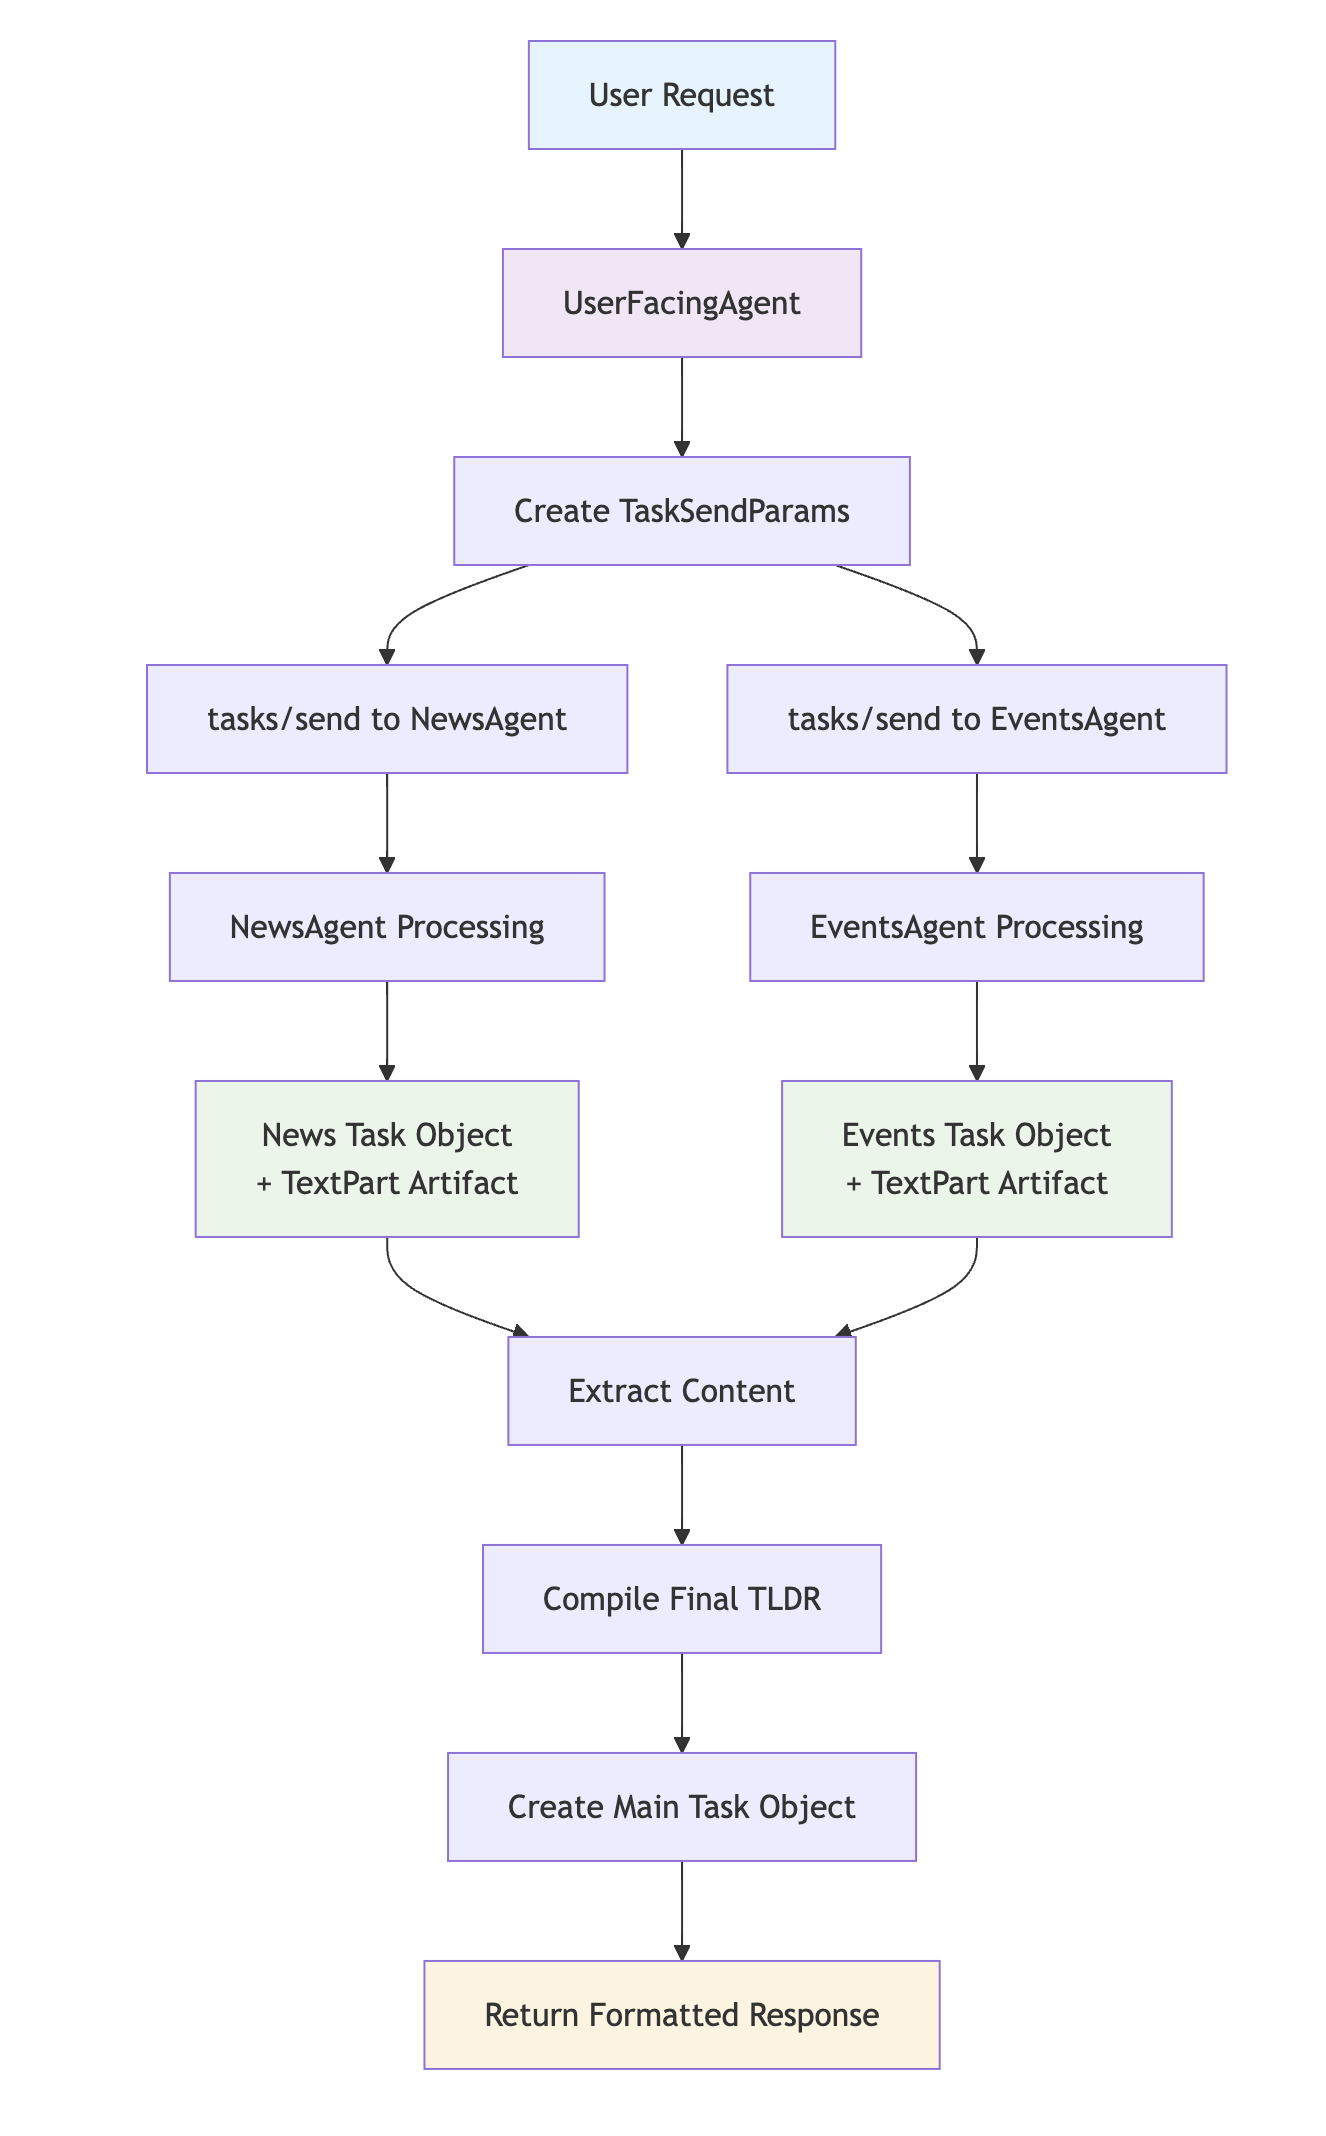

### Key A2A Concepts Demonstrated

In this tutorial, we've successfully demonstrated several core A2A concepts:

**✅ A2A Data Structures:**
- **TextPart**: Basic content containers
- **Message**: Conversational turns with roles and timestamps
- **Artifact**: Output containers for agent-generated content
- **TaskStatus**: State tracking for task progression
- **Task**: Central coordination object containing messages, artifacts, and status

**✅ A2A Communication Patterns:**
- **tasks/send**: Simulated JSON-RPC calls between agents
- **Agent Coordination**: Multi-agent collaboration on a single user request
- **Content Aggregation**: Combining outputs from multiple specialized agents

**✅ Real-World Applications:**
- **Modular Agent Design**: Specialized agents for different domains
- **Error Handling**: Graceful degradation when agents fail
- **Scalable Architecture**: Easy to add new agent types

---
This tutorial was written by [Yossi Elkrief (MaTriXy)](https://www.linkedin.com/in/yossielkrief/)